In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine) 

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
measurement = Base.classes.measurement  
station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(func.max(measurement.date)).first()[0]
last_date 

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

lateststr = session.query(measurement.date).order_by(measurement.date.desc()).first()
latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

sel = [measurement.date,measurement.prcp]
queryresult = session.query(*sel).filter(measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


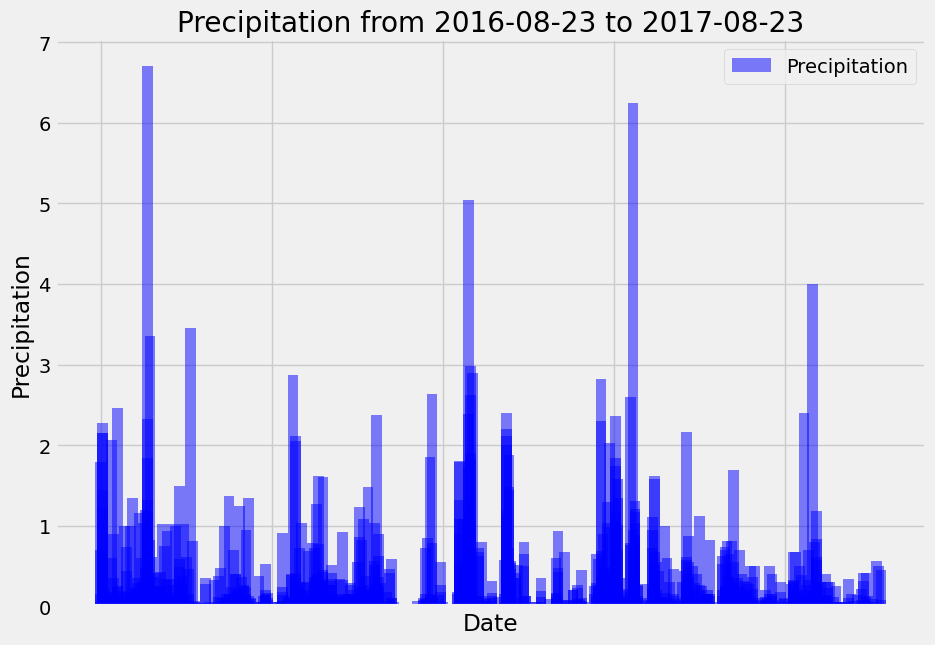

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

sel = [measurement.station,func.count(measurement.id)]
active_stations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
most_active_station_data = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station_data

(54.0, 85.0, 71.66378066378067)

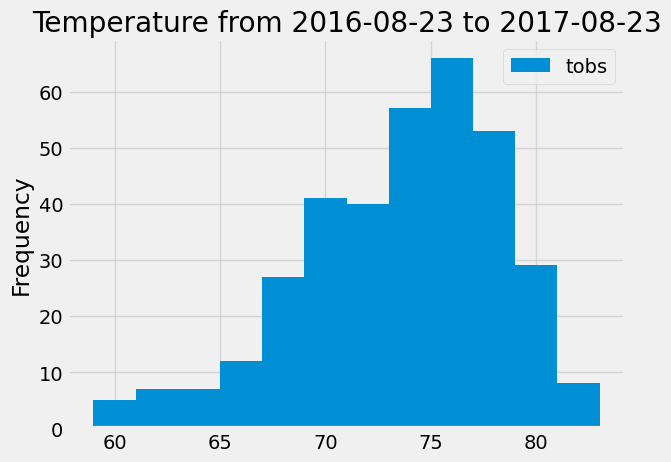

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter(measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {lateststr[0]}")
plt.legend()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()